# Grid search and training of SVM model for predicting player's strategic reasoning.

# 1. Setup

In [1]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import pickle
from itertools import cycle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths :
pathtoValData = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Val_SVM_Strategic_sophistication/'
pathtoTrainData = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Train_SVM_Strategic_sophistication/'
pathtoModel = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/SVM/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/SVM/Strategic_sophistication/'

In [4]:
# Define custom function for computing mAPk (mean Average Precision at k)
# Original source of code: https://books.google.it/books?id=ZbgAEAAAQBAJ&pg=PA64&lpg=PA64&dq=mapk+ml_metrics&source=bl&ots=Q1ZGckHUdP&sig=ACfU3U2vlYikcfzOCJAncxL8ueKH4pMX7w&hl=it&sa=X&ved=2ahUKEwjo-Mid57D0AhVGLewKHR_FCV4Q6AF6BAgNEAM#v=onepage&q=mapk%20ml_metrics&f=false
def pk(y_true, y_pred, k):
  if k==0:
    return 0
  y_pred = y_pred[:k]
  pred_set = set(y_pred)
  true_set = set(y_true)
  common_values = pred_set.intersection(true_set)
  return len(common_values) / len(y_pred[:k])

def apk(y_true, y_pred, k):
  pk_values = []
  for i in range(1, k+1):
    pk_values.append(pk(y_true, y_pred, i))
  if len(pk_values) ==0:
    return 0
  return sum(pk_values) / len(pk_values)

def mapk(y_true, y_pred, k):
  apk_values = []
  for i in range(len(y_true)):
    apk_values.append(
        apk(y_true[i], y_pred[i], k=k)
    )
  return sum(apk_values)/len(apk_values)

#2. Input Pipeline

In [5]:
def load_dataset(pathtoTrainData, pathtoValData):
  df_train = pd.read_pickle(pathtoTrainData + 'svm_df_train.pkl')
  x_train=df_train.iloc[:,:-1]
  y_train=df_train.iloc[:,-1]
  df_val = pd.read_pickle(pathtoValData + 'svm_df_val.pkl')
  x_val=df_val.iloc[:,:-1]
  y_val=df_val.iloc[:,-1]
  return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = load_dataset(pathtoTrainData, pathtoValData)

#3. Parameter Grid Search for SVC model

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 10, 100],
              'gamma': [10, 0.1, 0.0001],
              'kernel': ['rbf']}
svc=svm.SVC(class_weight='balanced', probability=False)
grid = GridSearchCV(svc, param_grid)
 
# fitting the model for grid search
grid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 10, 100], 'gamma': [10, 0.1, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, class_weight='balanced', gamma=0.0001)


In [ ]:
grid_predictions = grid.predict(x_val)
 
# print classification report
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       102
           1       0.60      0.71      0.65       147
           2       0.75      0.66      0.70       231

    accuracy                           0.63       480
   macro avg       0.60      0.61      0.60       480
weighted avg       0.64      0.63      0.63       480



#4. Refit model with best parameter and save it

In [6]:
# refit model with best parameter and save it:
svc=svm.SVC(C=10, kernel='rbf', gamma= 0.0001, probability=False)
print("The training of the model is started, please wait for while as it may take few minutes to complete")
svc.fit(x_train,y_train)

The training of the model is started, please wait for while as it may take few minutes to complete


SVC(C=10, gamma=0.0001)

In [ ]:
pickle.dump(svc,open(pathtoModel + 'svm_model_Strategic_sophistication.p','wb'))
print("Pickle is dumped successfully")

Pickle is dumped successfully


#5. Model performance

In [7]:
# Get unweighted and weighted average ROC score
y_preds=svc.predict(x_val)
y_preds = y_preds.tolist()
y_val = np.asarray(y_val)
y_val = y_val.tolist()
labels = [0,1,2]

# Binarize ytest with shape (n_samples, n_classes)
y_val_bin = label_binarize(y_val, classes=labels)
# Binarize ypreds with shape (n_samples, n_classes)
y_preds_bin = label_binarize(y_preds, classes=labels)
macro = roc_auc_score(y_val_bin, y_preds_bin,average='macro',multi_class='ovr')
weighted = roc_auc_score(y_val_bin, y_preds_bin,average='weighted',multi_class='ovr')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }

roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_val.csv', index= True)

In [8]:
# Compute mapk:
k = 16
mapk_val = mapk(y_val_bin, y_preds_bin,k)

# Save mapk_val:
mapk_val = pd.DataFrame({'mapk' : [mapk_val]})

mapk_val.to_csv(pathtoSave + 'mapk_val.csv', index= True)


In [ ]:
cls = classification_report(y_val, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_val.csv', index= True)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.58      0.28      0.38       102
           1       0.61      0.69      0.65       147
           2       0.69      0.79      0.74       231

    accuracy                           0.65       480
   macro avg       0.63      0.59      0.59       480
weighted avg       0.64      0.65      0.63       480



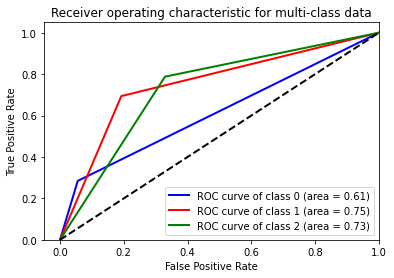

In [ ]:
# Plot ROC Curve

# original source of code for multiclass ROC cruve: https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 2
for i in range(n_classes):
    
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_preds_bin[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig(pathtoSave + 'roc_curve_val.png')